In [1]:
import argparse
from itertools import product as iterprod
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from argparse import ArgumentParser
import time
from datetime import datetime
from tqdm.autonotebook import tqdm
import pandas as pd

import matplotlib.pyplot as plt



/tmp/ipykernel_3869506/3724148964.py:12: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
import utils.data_2ch_processing as dp

from utils.UNeXt import UNet
from utils.loss_inference import loss_function_dict

import utils.nb_utils as nb_utils

import pprint

np.random.seed(11) # for reproducibility
torch.manual_seed(11)


%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
batch_size = 8
num_workers = 4

# Device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
pin_memory = True if torch.cuda.is_available() else False

In [4]:
device


device(type='cuda', index=0)

# Build dataset

In [5]:
# Dataset
directory  = '/net/projects/CLS/force_reference/data/240423_fixed_EGFP_zyxin_pFAK/normed_data_npy'
# directory  = '/net/projects/CLS/force_reference/data/ZyxAct_16kPa_small/'

test_cells = 'cell_3'


in_channels  = [[1]] # Example: [[4], [4,6], [4,6,7]]. Channel 4 is mask, 6 is zyxin, 7 is other protein (here actin)
out_channels = (2)
transform_kwargs = {'crop_size': 512,
                    'output_channels': out_channels,
                    'norm_output': {'rescale': 0.25, 'threshold': 0.0004}
                    }

dataset_kwargs = { 
                    'root': directory,
                    'force_load': False,
                    'test_split': 'bycell',
                    'test_cells': test_cells,
                    'in_channels': in_channels, 
                    'out_channels': out_channels, 
                    'transform_kwargs': transform_kwargs,
                    'frames_to_keep': 256,
                    'input_baseline_normalization': 'totally_normalize', # Comment on what these do
                    'output_baseline_normalization': 'totally_normalize',
                    'remake_dataset_csv': True
                     }


dataset = dp.CellDataset( **dataset_kwargs )

train_loader = dataset.get_loader(dataset.train_indices, batch_size, num_workers, pin_memory)
validation_loader = dataset.get_loader(dataset.test_indices, batch_size, num_workers, pin_memory)

{'crop_size': 512, 'output_channels': 7, 'norm_output': {'rescale': 0.25, 'threshold': 0.0004}}


In [6]:
dataset

# Some visualizations of the training data

The dataset class gets items by looking into a dataframe (`dataset.info`) where the folders and filenames are stored. Folders correspond to single cells, and each file is a frame of the time series. 

`dataset.info` contains the normalization values which the data is normalized by before it is passed to the NN. Forces are normalized by `dataset.info.F_mean` and the zyxin signal is normalized by `dataset.info.zyxin_baseline_out` and `dataset.info.zyxin_baseline_in`. Details about how these are generated can be found in the DataProcessing notebook.
    


In [7]:
df = dataset.info.copy()

df.head(10)

,folder,filename,frame,root
0,cell_3,norm_Control_zxyin_pFAK_cell_200.npy,200,/net/projects/CLS/force_reference/data/240423_...
1,cell_3,norm_Control_zxyin_pFAK_cell_201.npy,201,/net/projects/CLS/force_reference/data/240423_...
2,cell_3,norm_Control_zxyin_pFAK_cell_202.npy,202,/net/projects/CLS/force_reference/data/240423_...
3,cell_3,norm_Control_zxyin_pFAK_cell_203.npy,203,/net/projects/CLS/force_reference/data/240423_...
4,cell_3,norm_Control_zxyin_pFAK_cell_204.npy,204,/net/projects/CLS/force_reference/data/240423_...
5,cell_3,norm_Control_zxyin_pFAK_cell_205.npy,205,/net/projects/CLS/force_reference/data/240423_...
6,cell_3,norm_Control_zxyin_pFAK_cell_206.npy,206,/net/projects/CLS/force_reference/data/240423_...
7,cell_3,norm_Control_zxyin_pFAK_cell_207.npy,207,/net/projects/CLS/force_reference/data/240423_...
8,cell_3,norm_Control_zxyin_pFAK_cell_208.npy,208,/net/projects/CLS/force_reference/data/240423_...
9,cell_3,norm_Control_zxyin_pFAK_cell_209.npy,209,/net/projects/CLS/force_reference/data/240423_...


In [8]:
# Print test cells: 
print(dataset.test_cells)
print(dataset.test_indices)

{'test_cells': ['cell_3']}
[91 12 68 72 60 10 94 86 18 39 47 57 92 27 77 74 89  7 66 37 16  8  6  2
 59 82 49 11 50 83 19 53 54 61 14 70 25 32 98 88 56 79 22 42 41 40 95 81
 90 17 64]


In [9]:
dataset.info

,folder,filename,frame,root
0,cell_3,norm_Control_zxyin_pFAK_cell_200.npy,200,/net/projects/CLS/force_reference/data/240423_...
1,cell_3,norm_Control_zxyin_pFAK_cell_201.npy,201,/net/projects/CLS/force_reference/data/240423_...
2,cell_3,norm_Control_zxyin_pFAK_cell_202.npy,202,/net/projects/CLS/force_reference/data/240423_...
3,cell_3,norm_Control_zxyin_pFAK_cell_203.npy,203,/net/projects/CLS/force_reference/data/240423_...
4,cell_3,norm_Control_zxyin_pFAK_cell_204.npy,204,/net/projects/CLS/force_reference/data/240423_...
...,...,...,...,...
295,cell_1,norm_Control_zxyin_pFAK_cell_095.npy,95,/net/projects/CLS/force_reference/data/240423_...
296,cell_1,norm_Control_zxyin_pFAK_cell_096.npy,96,/net/projects/CLS/force_reference/data/240423_...
297,cell_1,norm_Control_zxyin_pFAK_cell_097.npy,97,/net/projects/CLS/force_reference/data/240423_...
298,cell_1,norm_Control_zxyin_pFAK_cell_098.npy,98,/net/projects/CLS/force_reference/data/240423_...


In [10]:
cell = 'cell_1'
frame = 5

idx = dataset.info.index[(dataset.info.folder==cell)&(dataset.info.frame==frame)].tolist()[0] # Get index in dataframe that contains the right cell and frame.
print(idx)

205


In [11]:
dataset.out_channels


7

In [12]:
sample = dataset[idx]

{'mask': torch.Size([1, 512, 512]), 'zyxin': torch.Size([1, 512, 512]), 'actin': torch.Size([1, 512, 512]), 'output': torch.Size([1, 512, 512])}


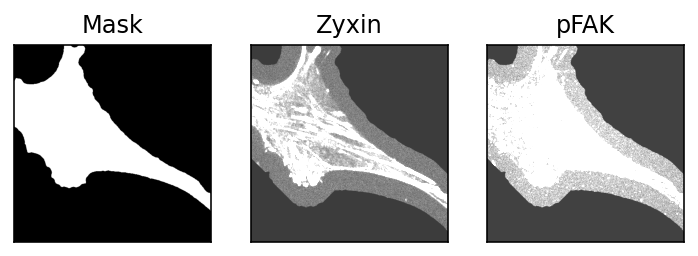

In [13]:
fig,ax=plt.subplots(1,3,figsize=(2*3, 4*2), dpi=144)


print({key: sample[key].shape for key in sample.keys()})

ax[0].set_title('Mask')
ax[0].imshow(sample['mask'].squeeze(), origin='lower', cmap='gray', vmax=1, vmin=0)
ax[1].set_title('Zyxin')
ax[1].imshow(sample['zyxin'].squeeze(), origin='lower', cmap='gray', vmax=0.1, vmin=0)
ax[2].set_title('pFAK')
ax[2].imshow(sample['output'][0,:,:].squeeze(), origin='lower', cmap='gray', vmax=0.1, vmin=0)


for a in ax.flat:
    a.set_xticks([])
    a.set_yticks([])

In [14]:
sample

{'mask': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 'zyxin': tensor([[[0.0236, 0.0236, 0.0236,  ..., 0.0236, 0.0236, 0.0236],
          [0.0236, 0.0236, 0.0236,  ..., 0.0236, 0.0236, 0.0236],
          [0.0236, 0.0236, 0.0236,  ..., 0.0236, 0.0236, 0.0236],
          ...,
          [0.0236, 0.0236, 0.0236,  ..., 0.0236, 0.0236, 0.0236],
          [0.0236, 0.0236, 0.0236,  ..., 0.0236, 0.0236, 0.0236],
          [0.0236, 0.0236, 0.0236,  ..., 0.0236, 0.0236, 0.0236]]]),
 'actin': tensor([[[0.0257, 0.0257, 0.0257,  ..., 0.0257, 0.0257, 0.0257],
          [0.0257, 0.0257, 0.0257,  ..., 0.0257, 0.0257, 0.0257],
          [0.0257, 0.0257, 0.0257,  ..., 0.0257, 0.0257, 0.0257],
          ...,
          [0.0257, 0.0257, 0.0257,  ..., 0.0257, 0.0257, 0.0257],
          [

# Build U-Net model with ConvNext blocks

In [15]:
n_lyr  = 3 # number of downsampling layers
ds_krnl= 4 # downsample kernel
n_ch   = 4 # number of channels in the beginning of the network
n_blocks = 4 # number of ConvNext blocks, wherever ConvNext blocks are used

prepend_hparams = {'start_channel': 1, 'resnet_channel': n_ch, 'end_channel': n_ch, 'N_blocks': n_blocks,                                         # Args for architecture
                    'kernel': 7,'stride': 1, 'inv_bottleneck_factor': 4, 'dilation': 1,'dropout_rate': 0.1, 'activation': 'gelu', 'batchnorm': 1} # Args for ConvNext blocks
encoder_hparams = {'n_ch': n_ch, 'n_layers': n_lyr, 'N_node_blocks': n_blocks, 'N_skip_blocks': n_blocks,
                    'downsample_kwargs': {'kernel': ds_krnl, 'activation': 'gelu', 'batchnorm': 1},
                    'interlayer_kwargs': {'kernel': 7,'stride': 1, 'inv_bottleneck_factor': 4, 'dilation': 1,'dropout_rate': 0.1, 'activation': 'gelu', 'batchnorm': 1}
                    }
decoder_hparams = {'n_layers': n_lyr, 'N_node_blocks': n_blocks, 'upsample_kernel': ds_krnl,
                    'kernel': 7,'stride': 1, 'inv_bottleneck_factor': 4, 'dilation': 1,'dropout_rate': 0.1, 'activation': 'gelu', 'batchnorm': 1}
append_hparams = {'start_channel': n_ch, 'resnet_channel': n_ch, 'end_channel': 2, 'N_blocks': n_blocks,
                    'kernel': 7,'stride': 1, 'inv_bottleneck_factor': 8, 'dilation': 1,'dropout_rate': 0.1, 'activation': 'gelu', 'batchnorm': 1} 
optimizer_hparams = {'LR': 0.001, 'schedule_rate': 0.99}
loss_hparams = {'loss_type': 'r_mse',
                'exp_weight': 0.0,
                'strainenergy_regularization': 0.0,
                'exp_schedule': {'type': 'linear', 'width': 310, 'e_crit': 30},
                'reg_schedule': {'type': 'linear', 'width': 310, 'e_crit': 30},
                'loss_kwargs': {'max_force': 8.}
               }





models = {}
for protein in ['zyxin1','zyxin2']:
    modelname = 'model_zyxin2pfak_50ep'

    logger_params = {'log_dir': f'./tensorboard_logs/{modelname}', 
                     'image_epoch_freq': 10,
                     'image_callbacks': 'vectorfield,hists',
                     'save_model_freq': 4}

    # Actually build model:
    model_kwargs={
                    'input_type':  protein[:-1], 
                    'prepend_hparams': prepend_hparams, 
                    'encoder_hparams': encoder_hparams, 
                    'decoder_hparams': decoder_hparams, 
                    'append_hparams': append_hparams, 
                    'optimizer_hparams': optimizer_hparams,
                    'loss_hparams': loss_hparams,
                    'logger_params': logger_params,
                    'name': 'model_0'}


    model = UNet( **model_kwargs, model_idx=0)
    model.to(device)
    
    models[protein] = model


In [16]:
models

{'zyxin1': UNet(
   (layers_encode): ModuleList(
     (0): ModuleList(
       (0-3): 4 x ConvNextCell(
         (conv0): Conv2d(4, 4, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=4)
         (conv1): Conv2d(4, 16, kernel_size=(1, 1), stride=(1, 1))
         (conv2): Conv2d(16, 4, kernel_size=(1, 1), stride=(1, 1))
         (bn): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (act): GELU(approximate='none')
       )
       (4): DownsampleLayer(
         (conv): Conv2d(4, 8, kernel_size=(4, 4), stride=(4, 4))
         (bn): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (act): GELU(approximate='none')
       )
     )
     (1): ModuleList(
       (0-3): 4 x ConvNextCell(
         (conv0): Conv2d(8, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=8)
         (conv1): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
         (conv2): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
  

In [17]:
protein[:-1]

'zyxin'

# Perform training

In [18]:
save_models = True
n_epochs = 50

pbar = tqdm(total=n_epochs*(np.minimum(dataset.frames_to_keep, len(dataset.train_indices))/batch_size))

t0 = time.time()
for e in range(n_epochs):
    pbar.set_description(f'Epoch {e}')
    loss_values_train = {}
    loss_values_val = {}

    for mkey in models.keys():
        models[mkey].reset_running_train_loss()
        models[mkey].reset_running_val_loss()

    for sample in train_loader: 
        for key in sample:
            sample[key] = sample[key].to(device)
        
        for mkey in models.keys():
            models[mkey].training_step(sample, epoch=e) # loss.backward() and optimizer step occur in here
        
        pbar.update(1)

    for sample in validation_loader:
        for key in sample:
            sample[key] = sample[key].to(device)
    
        for mkey in models.keys():
            models[mkey].validation_step(sample, epoch=e)

    for mkey in models.keys():
        models[mkey].scheduler.step()

    print("Epoch %u:\t Time: %0.2f \t(per epoch: %0.2f)"%(e, time.time()-t0, (time.time()-t0)/(e+1)))
    print(loss_values_train)
    # SAVE
    if save_models:
        # Log in tensorboard
        # for mkey in models.keys():
        #     model[mkey].log_images(epoch=e)
        #     model[mkey].log_scalars(epoch=e) 
            
        # Save models
        if e%(logger_params['save_model_freq'])==0 or e==n_epochs-1: 
            torch.save({'model': model.state_dict(),
                        'model_kwargs': model_kwargs,
                        'model_name': model.name,
                        'model_idx': model.index,
                        'dataset_kwargs': dataset_kwargs,
                        'test_cells': dataset.test_cells,
                        }, 
                       os.path.join( model.logdir, 'model.pt') )


Epoch 0:   0%|          | 0/1250.0 [00:00<?, ?it/s]

Epoch 1:   2%|▏         | 25/1250.0 [01:13<29:30,  1.45s/it] 

Epoch 0:	 Time: 73.03 	(per epoch: 73.03)
{}


Epoch 2:   4%|▍         | 50/1250.0 [01:40<14:55,  1.34it/s]  

Epoch 1:	 Time: 100.59 	(per epoch: 50.29)
{}


Epoch 3:   6%|▌         | 75/1250.0 [02:07<14:15,  1.37it/s]  

Epoch 2:	 Time: 127.41 	(per epoch: 42.47)
{}


Epoch 4:   8%|▊         | 100/1250.0 [02:34<14:02,  1.37it/s] 

Epoch 3:	 Time: 154.50 	(per epoch: 38.62)
{}


Epoch 5:  10%|█         | 125/1250.0 [03:01<14:04,  1.33it/s]

Epoch 4:	 Time: 181.74 	(per epoch: 36.35)
{}


Epoch 6:  12%|█▏        | 150/1250.0 [03:28<13:21,  1.37it/s]

Epoch 5:	 Time: 208.45 	(per epoch: 34.74)
{}


Epoch 7:  14%|█▍        | 175/1250.0 [03:56<13:04,  1.37it/s]

Epoch 6:	 Time: 236.26 	(per epoch: 33.75)
{}


Epoch 8:  16%|█▌        | 200/1250.0 [04:23<12:51,  1.36it/s]

Epoch 7:	 Time: 263.22 	(per epoch: 32.90)
{}


Epoch 9:  18%|█▊        | 225/1250.0 [04:50<12:27,  1.37it/s]

Epoch 8:	 Time: 290.27 	(per epoch: 32.25)
{}


Epoch 10:  20%|██        | 250/1250.0 [05:17<12:14,  1.36it/s]

Epoch 9:	 Time: 317.99 	(per epoch: 31.80)
{}


Epoch 11:  22%|██▏       | 275/1250.0 [05:44<12:02,  1.35it/s]

Epoch 10:	 Time: 345.00 	(per epoch: 31.36)
{}


Epoch 12:  24%|██▍       | 300/1250.0 [06:14<11:41,  1.35it/s]

Epoch 11:	 Time: 374.02 	(per epoch: 31.17)
{}


Epoch 13:  26%|██▌       | 325/1250.0 [06:43<11:52,  1.30it/s]

Epoch 12:	 Time: 403.20 	(per epoch: 31.02)
{}


Epoch 14:  28%|██▊       | 350/1250.0 [07:11<10:57,  1.37it/s]

Epoch 13:	 Time: 431.26 	(per epoch: 30.80)
{}


Epoch 15:  30%|███       | 375/1250.0 [07:38<10:38,  1.37it/s]

Epoch 14:	 Time: 458.38 	(per epoch: 30.56)
{}


Epoch 16:  32%|███▏      | 400/1250.0 [08:05<10:20,  1.37it/s]

Epoch 15:	 Time: 485.01 	(per epoch: 30.31)
{}


Epoch 17:  34%|███▍      | 425/1250.0 [08:33<10:14,  1.34it/s]

Epoch 16:	 Time: 513.34 	(per epoch: 30.20)
{}


Epoch 18:  36%|███▌      | 450/1250.0 [09:00<09:42,  1.37it/s]

Epoch 17:	 Time: 540.18 	(per epoch: 30.01)
{}


Epoch 19:  38%|███▊      | 475/1250.0 [09:26<09:33,  1.35it/s]

Epoch 18:	 Time: 566.92 	(per epoch: 29.84)
{}


Epoch 20:  40%|████      | 500/1250.0 [09:53<09:08,  1.37it/s]

Epoch 19:	 Time: 593.54 	(per epoch: 29.68)
{}


Epoch 21:  42%|████▏     | 525/1250.0 [10:20<08:50,  1.37it/s]

Epoch 20:	 Time: 620.93 	(per epoch: 29.57)
{}


Epoch 22:  44%|████▍     | 550/1250.0 [10:47<08:36,  1.36it/s]

Epoch 21:	 Time: 647.97 	(per epoch: 29.45)
{}


Epoch 23:  46%|████▌     | 575/1250.0 [11:16<08:08,  1.38it/s]

Epoch 22:	 Time: 676.61 	(per epoch: 29.42)
{}


Epoch 24:  48%|████▊     | 600/1250.0 [11:45<07:58,  1.36it/s]

Epoch 23:	 Time: 705.07 	(per epoch: 29.38)
{}


Epoch 25:  50%|█████     | 625/1250.0 [12:12<07:39,  1.36it/s]

Epoch 24:	 Time: 732.43 	(per epoch: 29.30)
{}


Epoch 26:  52%|█████▏    | 650/1250.0 [12:39<07:18,  1.37it/s]

Epoch 25:	 Time: 759.73 	(per epoch: 29.22)
{}


Epoch 27:  54%|█████▍    | 675/1250.0 [13:06<06:57,  1.38it/s]

Epoch 26:	 Time: 786.83 	(per epoch: 29.14)
{}


Epoch 28:  56%|█████▌    | 700/1250.0 [13:34<06:42,  1.37it/s]

Epoch 27:	 Time: 814.15 	(per epoch: 29.08)
{}


Epoch 29:  58%|█████▊    | 725/1250.0 [14:03<06:21,  1.38it/s]

Epoch 28:	 Time: 843.06 	(per epoch: 29.07)
{}


Epoch 30:  60%|██████    | 750/1250.0 [14:30<06:04,  1.37it/s]

Epoch 29:	 Time: 870.15 	(per epoch: 29.00)
{}


Epoch 31:  62%|██████▏   | 775/1250.0 [14:57<05:47,  1.37it/s]

Epoch 30:	 Time: 897.62 	(per epoch: 28.96)
{}


Epoch 32:  64%|██████▍   | 800/1250.0 [15:24<05:27,  1.37it/s]

Epoch 31:	 Time: 924.59 	(per epoch: 28.89)
{}


Epoch 33:  66%|██████▌   | 825/1250.0 [15:51<05:16,  1.34it/s]

Epoch 32:	 Time: 951.41 	(per epoch: 28.83)
{}


Epoch 34:  68%|██████▊   | 850/1250.0 [16:18<04:53,  1.36it/s]

Epoch 33:	 Time: 978.27 	(per epoch: 28.77)
{}


Epoch 35:  70%|███████   | 875/1250.0 [16:46<04:31,  1.38it/s]

Epoch 34:	 Time: 1006.41 	(per epoch: 28.75)
{}


Epoch 36:  72%|███████▏  | 900/1250.0 [17:14<04:16,  1.37it/s]

Epoch 35:	 Time: 1034.69 	(per epoch: 28.74)
{}


Epoch 37:  74%|███████▍  | 925/1250.0 [17:41<03:59,  1.36it/s]

Epoch 36:	 Time: 1061.75 	(per epoch: 28.70)
{}


Epoch 38:  76%|███████▌  | 950/1250.0 [18:08<03:39,  1.37it/s]

Epoch 37:	 Time: 1088.98 	(per epoch: 28.66)
{}


Epoch 39:  78%|███████▊  | 975/1250.0 [18:35<03:23,  1.35it/s]

Epoch 38:	 Time: 1115.33 	(per epoch: 28.60)
{}


Epoch 40:  80%|████████  | 1000/1250.0 [19:02<03:04,  1.36it/s]

Epoch 39:	 Time: 1142.26 	(per epoch: 28.56)
{}


Epoch 41:  82%|████████▏ | 1025/1250.0 [19:29<02:45,  1.36it/s]

Epoch 40:	 Time: 1169.23 	(per epoch: 28.52)
{}


Epoch 42:  84%|████████▍ | 1050/1250.0 [19:56<02:26,  1.36it/s]

Epoch 41:	 Time: 1196.42 	(per epoch: 28.49)
{}


Epoch 43:  86%|████████▌ | 1075/1250.0 [20:23<02:08,  1.36it/s]

Epoch 42:	 Time: 1223.63 	(per epoch: 28.46)
{}


Epoch 44:  88%|████████▊ | 1100/1250.0 [20:50<01:49,  1.36it/s]

Epoch 43:	 Time: 1250.83 	(per epoch: 28.43)
{}


Epoch 45:  90%|█████████ | 1125/1250.0 [21:17<01:30,  1.37it/s]

Epoch 44:	 Time: 1277.90 	(per epoch: 28.40)
{}


Epoch 46:  92%|█████████▏| 1150/1250.0 [21:48<01:15,  1.32it/s]

Epoch 45:	 Time: 1308.79 	(per epoch: 28.45)
{}


Epoch 47:  94%|█████████▍| 1175/1250.0 [22:16<00:54,  1.38it/s]

Epoch 46:	 Time: 1336.49 	(per epoch: 28.44)
{}


Epoch 48:  96%|█████████▌| 1200/1250.0 [22:44<00:36,  1.37it/s]

Epoch 47:	 Time: 1364.81 	(per epoch: 28.43)
{}


Epoch 49:  98%|█████████▊| 1225/1250.0 [23:12<00:18,  1.37it/s]

Epoch 48:	 Time: 1391.99 	(per epoch: 28.41)
{}


Epoch 49: 100%|██████████| 1250/1250.0 [23:34<00:00,  1.37it/s]

Epoch 49:	 Time: 1419.95 	(per epoch: 28.40)
{}


# Plot prediction on train cell

In [27]:
import tifffile
from utils.data67_processing import CellDataset, SubsetSampler

modelinfo = torch.load('./tensorboard_logs/model_zyxin2pfak_50ep_0/model.pt',  map_location=torch.device('cpu'))

dataset_kwargs = modelinfo['dataset_kwargs']
test_cells = dataset_kwargs['test_cells']

modelinfo['dataset_kwargs']['root'] = '/net/projects/CLS/force_reference/data/240423_fixed_EGFP_zyxin_pFAK/normed_data_npy'
modelinfo['dataset_kwargs']['transform_kwargs']['crop_size'] = 960
modelinfo['dataset_kwargs']['transform_kwargs']['rotate'] = False

model = UNet(**modelinfo['model_kwargs'], model_idx = 0)

model.load_state_dict(modelinfo['model'])

dataset = CellDataset(**modelinfo['dataset_kwargs'])

sampler = SubsetSampler(np.arange(len(dataset)))
loader = torch.utils.data.DataLoader(dataset, 
    batch_size=1,
    shuffle=False,
    sampler=sampler,
    pin_memory=True)

for cell in ['cell_1','cell_2','cell_3']:
    for frame in range(30):  

        idx = np.sort(dataset.info[dataset.info.folder==cell].index.values)
        idx = idx[frame]

        model.eval()
        model.to(torch.device('cuda:0'))

        sample = dataset[idx]
        for k in sample:
            sample[k] = sample[k].unsqueeze(0).to(torch.device('cuda:0'))

        preds = []
        for _ in range(5):
            pred = model(model.select_inputs(model.input_type, sample)).detach().cpu().numpy().squeeze()
            preds.append(pred)
            
        pred = np.mean(preds, axis=0) 
        target = sample['output'].detach().cpu().numpy().squeeze() 
        zyx = sample['zyxin'].detach().cpu().numpy().squeeze()
        pax = sample['actin'].detach().cpu().numpy().squeeze()


        fig,ax=plt.subplots(1,3,figsize=(8, 3*1), dpi=200)

        ax[0].set_title('Zyxin')
        ax[0].imshow(zyx,  cmap='gray', vmax=zyx.max()/4, vmin=0)
        if cell == 'cell_1':
            ax[0].set_xlabel('Testing set: ' + cell)
        else:
            ax[0].set_xlabel('Training set: ' + cell)
            
            
        ax[1].set_title('pFAK-Exp')
        ax[1].imshow(pax, cmap='gray', vmax=pax.max()/4, vmin=0)
        ax[1].set_xlabel('Frame '+ str(frame))
        
        ax[2].set_title('pFAK-NN')
        ax[2].imshow(pred.squeeze()[0],  cmap='gray', vmax=pred.squeeze()[0].max()/4, vmin=0)


        tifffile.imsave(os.path.join('../zyxin2pfak_results/tiff',cell + '_frame'+str(frame)+'.tif'),pred.squeeze()[0]/5)
        
        for a in ax.flat:
            a.set_xticks([])
            a.set_yticks([])
                    
        fig.savefig(os.path.join('../zyxin2pfak_results/plot', cell + '_frame'+str(frame)+'.png'))
        plt.close(fig) 


{'crop_size': 960, 'output_channels': 7, 'norm_output': {'rescale': 0.25, 'threshold': 0.0004}, 'rotate': False}


{'crop_size': 960, 'output_channels': 7, 'norm_output': {'rescale': 0.25, 'threshold': 0.0004}, 'rotate': False}
torch.Size([1, 1, 960, 960])
(1, 2, 960, 960)


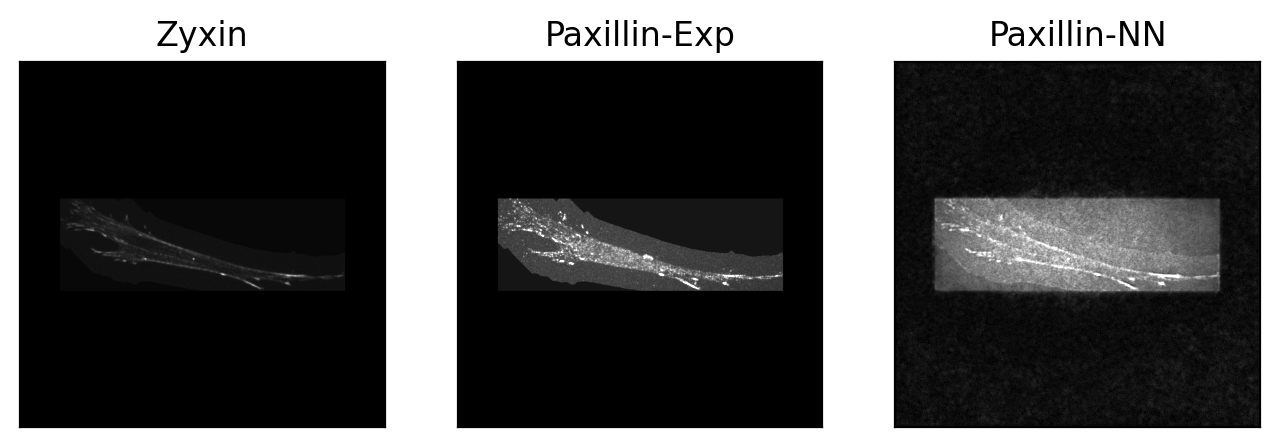

In [29]:
fig,ax=plt.subplots(1,3,figsize=(8, 3*1), dpi=200)

model = models['zyxin2']

eval_dataset_kwargs = dataset_kwargs
eval_dataset_kwargs['transform_kwargs']['crop_size'] = 960
eval_dataset_kwargs['exclude_frames'] = None
dataset_eval = dp.CellDataset( **eval_dataset_kwargs )

cell = 'cell_1'
frame = 0


idx = dataset_eval.info.index[(dataset_eval.info.folder==cell)&(dataset_eval.info.frame==frame)].tolist()[0] # Get index in dataframe that contains the right cell and frame.


sample = dataset_eval[idx] # get item

input_image = model.select_inputs(model.input_type, sample).unsqueeze(0).to(device)
print(input_image.shape)

pred = model(input_image).detach().cpu().numpy()

print(pred.shape)


ax[0].set_title('Zyxin')
ax[0].imshow(sample['zyxin'].squeeze(), origin='lower', cmap='gray', vmax=1, vmin=0)

ax[1].set_title('Paxillin-Exp')
ax[1].imshow(sample['actin'].squeeze(), origin='lower', cmap='gray', vmax=1, vmin=0)

ax[2].set_title('Paxillin-NN')
ax[2].imshow(pred.squeeze()[0], origin='lower', cmap='gray', vmax=1, vmin=0)

for a in ax.flat:
    a.set_xticks([])
    a.set_yticks([])

# Performance on test cell
## It seems to underpredict quite dramatically, but we don't necessarily expect great generalization because the network was trained on an extremely small dataset (~180 frames).

torch.Size([1, 1, 960, 960])
(1, 2, 960, 960)


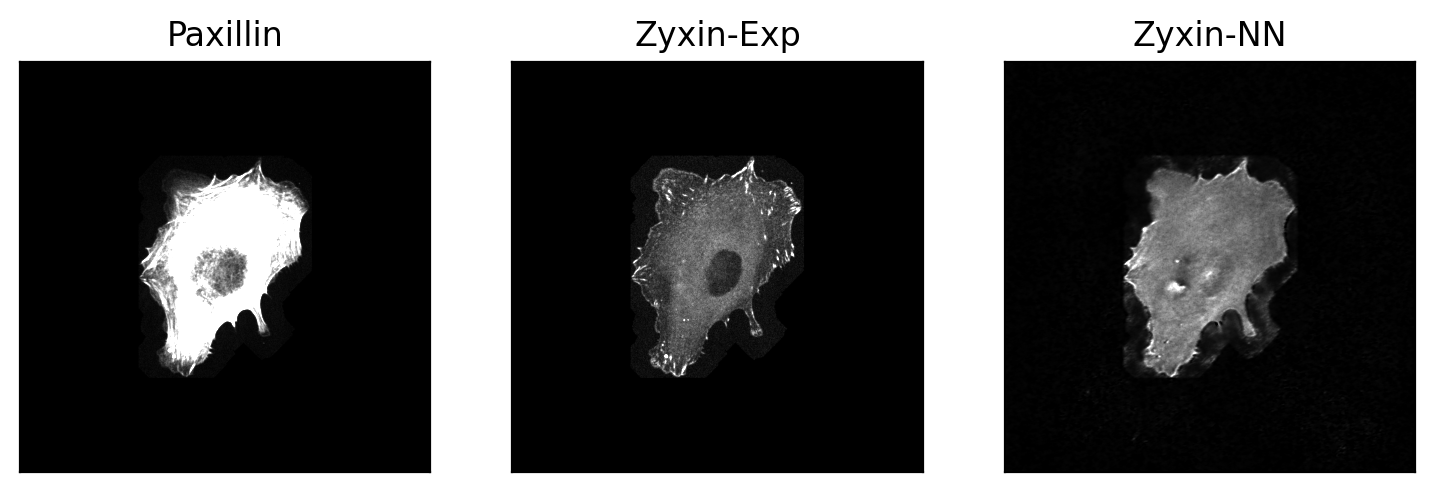

In [ ]:
fig,ax=plt.subplots(1,3,figsize=(3*3, 3*1), dpi=200)

model = models['actin1']

eval_dataset_kwargs = dataset_kwargs
eval_dataset_kwargs['transform_kwargs']['crop_size'] = 960
eval_dataset_kwargs['exclude_frames'] = None
dataset_eval = dp.CellDataset( **eval_dataset_kwargs )

cell = 'cell_1'
frame = 100

idx = dataset_eval.info.index[(dataset_eval.info.folder==cell)&(dataset_eval.info.frame==frame)].tolist()[0] # Get index in dataframe that contains the right cell and frame.


sample = dataset_eval[idx] # get item

input_image = model.select_inputs(model.input_type, sample).unsqueeze(0).to(device)
print(input_image.shape)

pred = model(input_image).detach().cpu().numpy()

print(pred.shape)

ax[0].set_title('Paxillin')
ax[0].imshow(sample['actin'].squeeze(), origin='lower', cmap='gray', vmax=10, vmin=0)

ax[1].set_title('Zyxin-Exp')
ax[1].imshow(sample['zyxin'].squeeze(), origin='lower', cmap='gray', vmax=300, vmin=0)

ax[2].set_title('Zyxin-NN')
ax[2].imshow(pred.squeeze()[0], origin='lower', cmap='gray', vmax=1000, vmin=0)


for a in ax.flat:
    a.set_xticks([])
    a.set_yticks([])